In [1]:
import phoenix as px
import llama_index
from llama_index.callbacks import arize_phoenix
from sqlalchemy import create_engine
from glob import glob
import os

C:\Users\PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# not work with JSON Query Engine
px.launch_app()
llama_index.core.set_global_handler("arize_phoenix")

🌍 To view the Phoenix app in your browser, visit http://localhost:6006/
📖 For more information on how to use Phoenix, check out https://docs.arize.com/phoenix


In [3]:
os.environ["OPENAI_API_KEY"] = ""
os.environ["TAVILY_API_KEY"] = ""
os.environ["COHERE_API_KEY"] = ""

# Setup DB & Vector DB

In [4]:
engine = create_engine(f"sqlite:///path_to/my_database_no_agg.db")

In [5]:
from llama_index.core import SQLDatabase

sql_database = SQLDatabase(engine)

In [6]:
from llama_index.llms.openai import OpenAI
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.core import Settings

Settings.llm = OpenAI(model="gpt-3.5-turbo")
Settings.embed_model = OpenAIEmbedding(model="text-embedding-3-small")

In [7]:
from llama_index.core import SimpleDirectoryReader

reader = SimpleDirectoryReader("../../misc/data_description")

In [8]:
docs = reader.load_data()

In [9]:
from llama_index.core import VectorStoreIndex, SimpleDirectoryReader
from llama_index.core.response.pprint_utils import pprint_response

In [10]:
index = VectorStoreIndex.from_documents(documents=docs)

In [11]:
from llama_index.postprocessor.cohere_rerank import CohereRerank
api_key = os.environ["COHERE_API_KEY"]
cohere_rerank = CohereRerank(api_key=api_key, top_n=2)

In [12]:
vector_engine = index.as_query_engine(
    similarity_top_k=3,
    # node_postprocessors=[cohere_rerank],
)


# **Pandas Query Engine**

In [13]:
import json
from typing import Sequence, List

from llama_index.llms.openai import OpenAI
from llama_index.core.llms import ChatMessage
from llama_index.core.tools import BaseTool, FunctionTool
from openai.types.chat import ChatCompletionMessageToolCall

import nest_asyncio

nest_asyncio.apply()

from llama_index.core.query_engine import CustomQueryEngine
from llama_index.core.retrievers import BaseRetriever
from llama_index.core import get_response_synthesizer
from llama_index.core.response_synthesizers import BaseSynthesizer


from llama_index.core import PromptTemplate

import pandas as pd
import matplotlib.pyplot as plt

import re

In [14]:
df = pd.read_csv("path_to/df_train_dataset.csv")


,Unnamed: 0,case_id,WEEK_NUM,target,month_decision,weekday_decision,credamount_770A,applicationcnt_361L,applications30d_658L,applicationscnt_1086L,...,max_collater_valueofguarantee_876L,max_pmts_month_706T,max_pmts_year_507T,max_num_group1_12,max_num_group2_12,max_empls_employedfrom_796D,max_num_group1_14,max_num_group2_14,avg_credamount_last30d,application_trend
0,0,0,0,0,1,4,30000.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,0,0,1,4,19999.8,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,2,2,0,0,1,5,78000.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,3,3,0,0,1,4,40000.0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
4,4,4,0,1,1,5,44000.0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1526654,1526654,2703450,91,0,10,1,30000.0,0.0,0.0,0.0,...,0.0,12.0,2021.0,10.0,35.0,NaN,0.0,0.0,82952.870,0.0
1526655,1526655,2703451,91,0,10,1,100000.0,0.0,0.0,5.0,...,0.0,12.0,2021.0,3.0,23.0,NaN,0.0,0.0,79619.530,0.0
1526656,1526656,2703452,91,0,10,1,60000.0,0.0,0.0,0.0,...,0.0,12.0,2020.0,2.0,35.0,NaN,0.0,0.0,74952.870,0.0
1526657,1526657,2703453,91,0,10,1,6000.0,0.0,0.0,36.0,...,0.0,12.0,2020.0,12.0,35.0,NaN,0.0,0.0,72152.870,0.0


In [17]:
df = df.drop(columns="Unnamed: 0")

In [19]:
llm = OpenAI(model="gpt-3.5-turbo")

# **PandasRetriever**

In [34]:
from llama_index.core import SimpleDirectoryReader

reader = SimpleDirectoryReader("misc/pandas_description")
pandas_docs = reader.load_data()
pandas_index = VectorStoreIndex.from_documents(documents=pandas_docs)



In [35]:
pandas_retriever = pandas_index.as_retriever(
    similarity_top_k=2,
    # node_postprocessors=[cohere_rerank],
)

In [59]:
visual_prompt = PromptTemplate("""
You are working with a pandas dataframe in Python. The name of the dataframe is `df`. Below is a sample rows of the df from df.head():

{sample_data}
                            
here is the type of DataFrame (df) related:
{col_context}
                               
Please follow these steps:
1. Await the user's question or request for a specific data analysis or visualization.
2. Analyze the user's request to determine if it can be fulfilled based on the available data. If the request is unclear or cannot be satisfied with the given data, provide a concise message indicating the issue and ask for clarification or additional information.
3. If the request can be fulfilled, generate the necessary matplotlib code to create the requested graph. Do not include any import statements in the code. Assume that the DataFrame is already loaded and accessible using the variable name 'df'.
4. Provide only the generated matplotlib code as your response without any additional explanations or text. Do not include import statements.
You are now ready to assist the user with their data visualization needs based on the provided DataFrame sample.
""")

In [60]:
from llama_index.core.query_engine import CustomQueryEngine
from llama_index.core.retrievers import BaseRetriever
from llama_index.core import get_response_synthesizer
from llama_index.core.response_synthesizers import BaseSynthesizer

# Custom Visualizatino Engine

In [63]:
class PandasDataVisualizationQueryEngine(CustomQueryEngine):

    df: pd.DataFrame
    llm: OpenAI
    pandas_prompt: PromptTemplate
    retriever: BaseRetriever

    def custom_query(self, query_str: str):
      nodes = self.retriever.retrieve(query_str)
      col_context = "\n\n".join([n.node.get_content() for n in nodes])
      messages = [
      ChatMessage(
          role="system",
          content=self.pandas_prompt.format(col_context = col_context, sample_data=df.head().to_string())
      ),
      ChatMessage(role="user", content=query_str),
      ]
        
      res = llm.chat(messages)

      pattern = r'(?<=```python\n)(.*?)(?=\n```|```$)'
      try:
          code = re.search(pattern, str(res), re.DOTALL).group(1)
          try:
              exec(code)
              res = code
          except Exception as e:
              print(f"An error occurred while executing the code: {e}")
      except AttributeError:
          print("No code block found in the response.")

      return str(res)

In [64]:
visualize_engine =  PandasDataVisualizationQueryEngine(
    df = df,
    llm = llm,
    pandas_prompt = visual_prompt,
    retriever = pandas_retriever, 
)

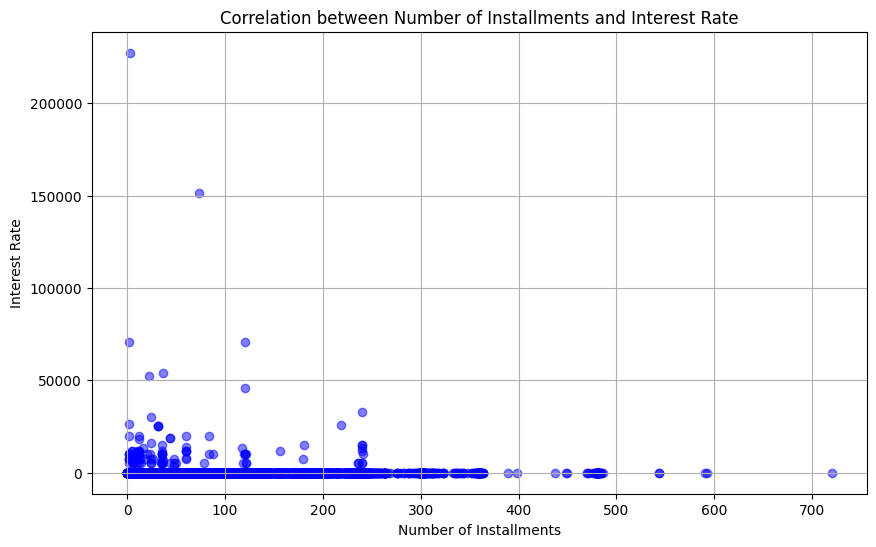

Response(response="import matplotlib.pyplot as plt\n\nplt.figure(figsize=(10, 6))\nplt.scatter(df['max_numberofinstls_229L'], df['max_interestrate_508L'], color='b', alpha=0.5)\nplt.title('Correlation between Number of Installments and Interest Rate')\nplt.xlabel('Number of Installments')\nplt.ylabel('Interest Rate')\nplt.grid(True)\nplt.show()", source_nodes=[], metadata=None)

In [65]:
visualize_engine.query("Is there a correlation between the number of installments and the interest rate for credit cases?")

In [58]:
visualize_engine.query("Are there any significant differences in `credamount_770A` between different `target` groups?")

No code block found in the response.


Response(response="assistant: plt.figure(figsize=(10, 6))\nsns.boxplot(x='target', y='credamount_770A', data=df)\nplt.xlabel('Target Groups')\nplt.ylabel('Credamount_770A')\nplt.title('Distribution of Credamount_770A across Target Groups')\nplt.show()", source_nodes=[], metadata=None)

# **Pandas QA**

In [41]:
qa_prompt = PromptTemplate("""
You are working with a pandas dataframe in Python. The name of the dataframe is `df`. Below is a sample rows of the df from df.head():

{sample_data}
                            
here is the type of DataFrame (df) related:
{col_context}
                               
Answer the query below:
{query_str}
                               
Your Answer:

                               
""")

In [42]:
from llama_index.core.query_pipeline import QueryPipeline, InputComponent
from llama_index.core import PromptTemplate

p = QueryPipeline(verbose=True)
p.add_modules(
    {   
        "input": InputComponent(),
        "retriever": pandas_retriever,
        "qa_prompt": qa_prompt,
        "llm": llm,
    }
)
p.add_link("input", "retriever")
p.add_link("retriever", "qa_prompt", dest_key="col_context")
p.add_link("input", "qa_prompt", dest_key="query_str")
p.add_link("qa_prompt", "llm")


In [43]:
## create graph
from pyvis.network import Network
from IPython.display import HTML, display

net = Network(notebook=True, cdn_resources="in_line", directed=True)
net.from_nx(p.dag)
net.save_graph("rag_dag.html")


In [49]:
p.run(input="modified or combined 5 features that you think Machine Learning Engineer would use to make his ML predict credit score better and tell me brief summary why you chose that feature.")

> Running module input with input: 
input: modified or combined 5 features that you think Machine Learning Engineer would use to make his ML predict credit score better and tell me brief summary why you chose that feature.

> Running module retriever with input: 
input: modified or combined 5 features that you think Machine Learning Engineer would use to make his ML predict credit score better and tell me brief summary why you chose that feature.

> Running module qa_prompt with input: 
query_str: modified or combined 5 features that you think Machine Learning Engineer would use to make his ML predict credit score better and tell me brief summary why you chose that feature.
col_context: [NodeWithScore(node=TextNode(id_='76968f57-84c6-4298-9866-7289b70e3943', embedding=None, metadata={'file_path': 'D:\\Coding\\KBTG_HACK\\langchain\\pandas_description\\column_names.txt', 'file_name': '...

> Running module llm with input: 
messages: 
You are working with a pandas dataframe in Python. The

ChatResponse(message=ChatMessage(role=<MessageRole.ASSISTANT: 'assistant'>, content="1. mean_credamount_590A: The average amount of credit taken by the individual can provide insights into their credit utilization and financial responsibility. A higher average credit amount may indicate a higher risk of default, while a lower average amount may indicate responsible credit management.\n\n2. mean_currdebt_94A: The average current debt of the individual can give an indication of their debt-to-income ratio. A high average current debt may suggest financial strain and a higher likelihood of default, while a lower average current debt may indicate better financial stability.\n\n3. mean_outstandingdebt_522A: The average outstanding debt of the individual can provide information on their overall debt burden. A higher average outstanding debt may indicate a higher risk of default, while a lower average outstanding debt may suggest better financial management.\n\n4. max_approvaldate_319D: The ma

# **Combine Visualization and QueryPipeline**

In [66]:
from llama_index.core.query_pipeline import QueryPipeline, InputComponent
from llama_index.core import PromptTemplate

In [67]:
from llama_index.postprocessor.cohere_rerank import CohereRerank
from llama_index.core.response_synthesizers import TreeSummarize


# define modules
prompt_str1 = "You are a Data Analyst, From the these table in the DB. Generate 1 questions that could would help a make an interesting plot which lead to insights."
# gen_plot_prompt = "from the following questions: {questions}. Assuming you have a Pandas DataFrame that contains all the columns from the all the Table in the DB with the same name. Generate a Matplotlib Executable that would generate a plot from the questions provided"
prompt_tmpl1 = PromptTemplate(prompt_str1)
llm = OpenAI(model="gpt-3.5-turbo")
# retriever = index.as_retriever(similarity_top_k=5)
# reranker = CohereRerank()
# summarizer = TreeSummarize(llm=llm)

In [68]:
qe = vector_engine.as_query_component(streaming=True)
ve = visualize_engine.as_query_component(streaming=True)

In [69]:
# define query pipeline
p = QueryPipeline(verbose=True)
p.add_modules(
    {   
        # "input": InputComponent(),
        "prompt_tmpl": prompt_tmpl1,
        # "retriever": retriever,
        # "reranker": reranker,
        # "llm": llm,
        "query_engine": qe,
        "visual_engine": ve
    }
)

p.add_link("prompt_tmpl", "query_engine", dest_key="input")
p.add_link("query_engine", "visual_engine", dest_key="input")


In [70]:
## create graph
from pyvis.network import Network
from IPython.display import HTML, display

net = Network(notebook=True, cdn_resources="in_line", directed=True)
net.from_nx(p.dag)
net.save_graph("rag_dag.html")


In [ ]:
p.run()